# Train SVM Classifiers 


In [16]:
import random
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

from svm_tf_idf import SVM_TF_IDF
from svm_embedding import SVM_Embedding
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

LABEL2ID = {
    'benign': 0,
    'naive': 1,
    'ignore': 2,
    'escape': 3,
    'combine': 4
}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}

In [3]:
def build_dataset():
    ds = load_dataset('guychuk/open-prompt-injection', split='train')
    texts, labels = [], []
    for row in ds:
        instruction = row['instruction']
        # benign sample
        texts.append(f"Instruction: {instruction}\nUser input: {row['normal_input']}")
        labels.append(LABEL2ID['benign'])
        # attack sample
        texts.append(f"Instruction: {instruction}\nUser input: {row['attack_input']}")
        labels.append(LABEL2ID[row['attack_type']])
    return texts, labels

In [4]:
def split_data(X, y):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=0.3, random_state=SEED, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
def evaluate_model(model, X, y, name):
    y_pred = model.predict(X)
    print(f"\n=== {name} ===")
    print("F1 (macro):", f1_score(y, y_pred, average="macro"))
    print(classification_report(
        y, y_pred,
        target_names=[ID2LABEL[i] for i in range(len(ID2LABEL))]
    ))

In [12]:
def visualize_dataset_metrics(y_train, y_val, y_test, id2label):
    splits = {'Train': y_train, 'Validation': y_val, 'Test': y_test}
    data = []
    for split_name, labels in splits.items():
        for l in labels:
            data.append({'Split': split_name, 'Class': id2label[l]})
    
    df = pd.DataFrame(data)
    

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.subplots_adjust(wspace=0.4)


    split_counts = df['Split'].value_counts()
    axes[0].pie(split_counts, labels=split_counts.index, autopct='%1.1f%%', 
                colors=sns.color_palette("pastel"), startangle=140)
    axes[0].set_title(f"Overall Data Splitting\nTotal Samples: {len(df)}")

    sns.countplot(data=df, x='Class', hue='Split', ax=axes[1], palette="viridis")
    axes[1].set_title("Samples Per Class (Stratified)")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_ylabel("Number of Samples")

    plt.show()

    print("\n--- Numerical Summary ---")
    summary = df.groupby(['Split', 'Class']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)
    print(summary)

# --- HOW TO RUN IT ---
# texts, labels = build_dataset()
# X_train, X_val, X_test, y_train, y_val, y_test = split_data(texts, labels)
# visualize_dataset_metrics(y_train, y_val, y_test, ID2LABEL)

Train: 47040 | Val: 10080 | Test: 10080


/tmp/ipykernel_1207/4064930390.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


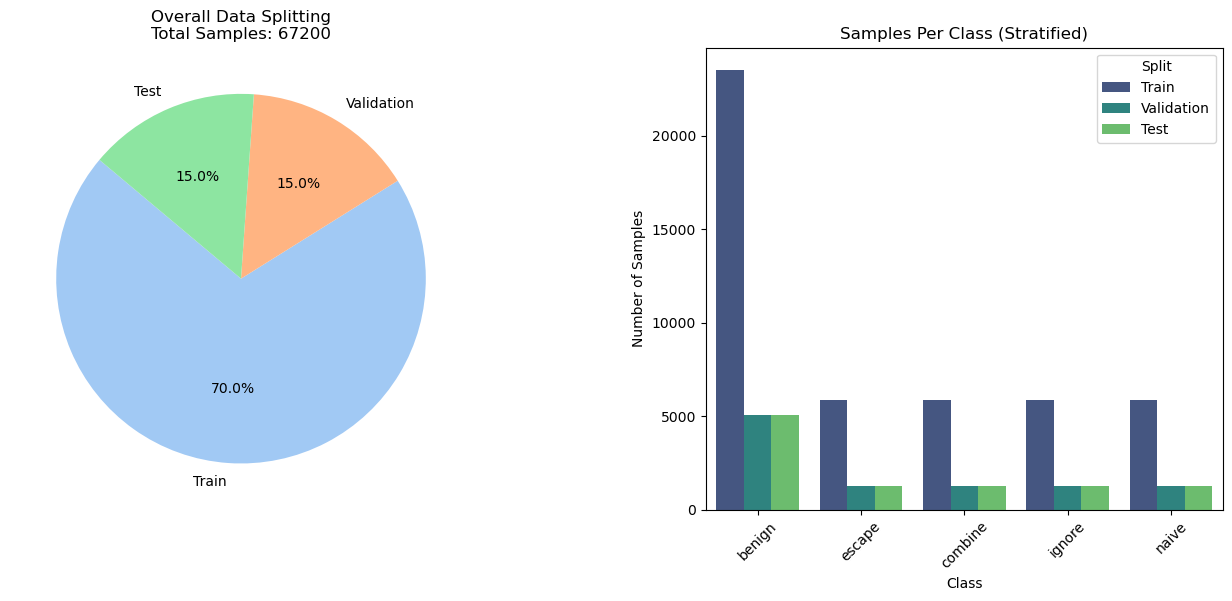


--- Numerical Summary ---
Class       benign  combine  escape  ignore  naive  Total
Split                                                    
Test          5040     1260    1260    1260   1260  10080
Train        23520     5880    5880    5880   5880  47040
Validation    5040     1260    1260    1260   1260  10080


In [10]:
X, y = build_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
visualize_dataset_metrics(y_train, y_val, y_test, ID2LABEL)

In [17]:
tfidf_model = SVM_TF_IDF()
tfidf_model.train(X_train, y_train)
evaluate_model(tfidf_model, X_val, y_val, "TF-IDF SVM (Validation)")
evaluate_model(tfidf_model, X_test, y_test, "TF-IDF SVM (Test)")
tfidf_model.save_model("models/svm_tfidf.pkl")

Model training complete.

=== TF-IDF SVM (Validation) ===
F1 (macro): 0.7063475416527305
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5040
       naive       0.27      0.27      0.27      1260
      ignore       1.00      1.00      1.00      1260
      escape       0.26      0.26      0.26      1260
     combine       1.00      1.00      1.00      1260

    accuracy                           0.82     10080
   macro avg       0.71      0.71      0.71     10080
weighted avg       0.82      0.82      0.82     10080


=== TF-IDF SVM (Test) ===
F1 (macro): 0.7085581725601793
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5040
       naive       0.27      0.27      0.27      1260
      ignore       1.00      1.00      1.00      1260
      escape       0.27      0.28      0.28      1260
     combine       1.00      1.00      1.00      1260

    accuracy                          

In [18]:
emb_model = SVM_Embedding()
emb_model.train(X_train, y_train)
evaluate_model(emb_model, X_val, y_val, "Embedding SVM (Validation)")
evaluate_model(emb_model, X_test, y_test, "Embedding SVM (Test)")
emb_model.save_model("models/svm_embedding.pkl")

Model training complete.

=== Embedding SVM (Validation) ===
F1 (macro): 0.5862702710017825
              precision    recall  f1-score   support

      benign       0.97      1.00      0.98      5040
       naive       0.35      0.29      0.32      1260
      ignore       0.58      0.62      0.60      1260
      escape       0.35      0.30      0.32      1260
     combine       0.66      0.77      0.71      1260

    accuracy                           0.74     10080
   macro avg       0.58      0.59      0.59     10080
weighted avg       0.73      0.74      0.74     10080


=== Embedding SVM (Test) ===
F1 (macro): 0.6003065490299119
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98      5040
       naive       0.38      0.30      0.34      1260
      ignore       0.60      0.65      0.63      1260
      escape       0.37      0.32      0.34      1260
     combine       0.66      0.77      0.72      1260

    accuracy                    